<a href="https://colab.research.google.com/github/Tonyz4516/detector-for-masked-faces/blob/master/mask_detector_mixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image

In [ ]:
train_embeddings = pd.read_csv("data/embarray_train.txt", sep=" ", header=None)
test_embeddings = pd.read_csv("data/embarray_test.txt", sep=" ", header=None)
train_labels = pd.read_csv("data/labels_train.txt", sep=" ", header=None)
test_labels = pd.read_csv("data/labels_test.txt", sep=" ", header= None)
train_labels.columns = ["label"]
test_labels.columns = ["label"]

In [ ]:
# use SVM directly here 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

X = train_embeddings.values
y = train_labels.values
X_test = test_embeddings.values
y_test = test_labels.values
acc = {}
train_acc = {}
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in tqdm(range(len(kernels))):
    kernel = kernels[i]
    svm = SVC(random_state = 0, kernel=kernel)
    svm.fit(X, y)
    y_hat = svm.predict(X_test)
    acc[kernel] = metrics.accuracy_score(y_test, y_hat)
    train_acc[kernel] = metrics.accuracy_score(y, svm.predict(X))
    
print(acc)
print(train_acc)


  0%|          | 0/4 [00:00<?, ?it/s]/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 25%|██▌       | 1/4 [53:34<2:40:44, 3214.88s/it]/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
 50%|█████     | 2/4 [5:32:04<4:02:06, 7263.33s

{'linear': 0.9513465854440526, 'poly': 0.6007801645826654, 'rbf': 0.9435716575825586, 'sigmoid': 0.9388692957144383}
{'linear': 0.9535581988256301, 'poly': 0.6055556049071252, 'rbf': 0.9452434463582983, 'sigmoid': 0.940624139432003}


# miss classification analysis

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

X = train_embeddings.values
y = train_labels.values
X_test = test_embeddings.values
y_test = test_labels.values
import time
start = time.time()
logreg = LogisticRegression(random_state=1).fit(X, y)
end = time.time()
print(end - start)
y_hat = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)
acc = logreg.score(X_test, y_test)

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


11.623427152633667


In [ ]:
# run the logistic regression before run this chuck

miss_classified_test_ls = [id for id, item in enumerate(y_test) if item!= y_hat[id]]
len(miss_classified_test_ls)

1877

In [ ]:
# read the image paths
train_image = pd.read_csv("data/paths_labels_train.txt", sep=" ", header=None, index_col= 0)
test_image = pd.read_csv("data/paths_labels_test.txt", sep=" ", header= None, index_col= 0)
train_image.columns = ['path','label']
test_image.columns = ['path','label']
train_image.index.name = None
test_image.index.name = None

In [ ]:
# check the miss classified image
miss_classified_test = test_image.iloc[miss_classified_test_ls,:]
predicted_label = pd.DataFrame(data=y_hat,  columns=["predicted_label"])
miss_classified_test = miss_classified_test.merge(predicted_label, left_index = True, right_index = True)
print(miss_classified_test.shape)
miss_classified_test.head()

(1877, 3)


,path,label,predicted_label
125,test\face\10185.jpg,0,1
128,test\face\10188.jpg,0,1
179,test\face\1027.jpg,0,1
218,test\face\10331.jpg,0,1
239,test\face\10378.jpg,0,1


In [ ]:
# seperate the miss classified images to fp and fn

fp = miss_classified_test[(miss_classified_test["label"] == 0 )& (miss_classified_test["predicted_label"] == 1)]
fn = miss_classified_test[(miss_classified_test["label"] == 1 )& (miss_classified_test["predicted_label"] == 0)]
print(fp.shape)
print(fn.shape)

(878, 3)
(999, 3)


In [ ]:
folder = "data/"
def miss_gen(df):
    for i in df.index:
    
        path = (folder + df['path'][i]).replace("\\","/")
        img = Image.open(path)
        img_resize = img.resize((160,160))
        plt.figure()
        f, axarr = plt.subplots(1,2)
        if img.size[0] + img.size[1]<200:
            yield axarr[0].imshow(img),axarr[1].imshow(img_resize),print(img.size),print(img_resize.size),print("true class:", fn["label"][i], ",", "predicted class:", fn["predicted_label"][i]), print(path)
img_miss = miss_gen(fn)

(56, 75)
(160, 160)
true class: 1 , predicted class: 0
data/test/mask/14113.jpg


(<matplotlib.image.AxesImage at 0x7fc6327c49e8>,
 None,
 None,
 None,
 None)

<Figure size 432x288 with 0 Axes>

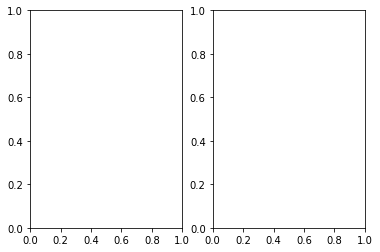

<Figure size 432x288 with 0 Axes>

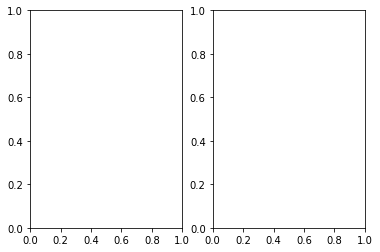

<Figure size 432x288 with 0 Axes>

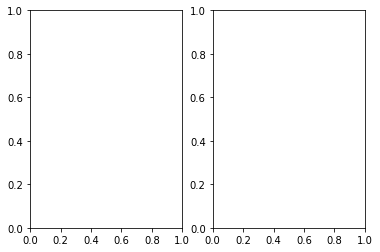

<Figure size 432x288 with 0 Axes>

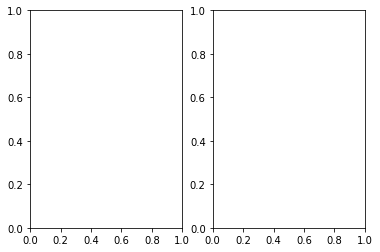

<Figure size 432x288 with 0 Axes>

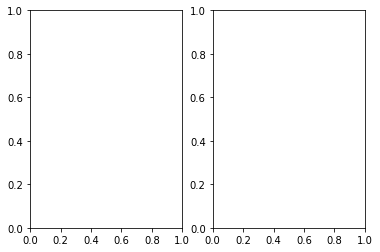

<Figure size 432x288 with 0 Axes>

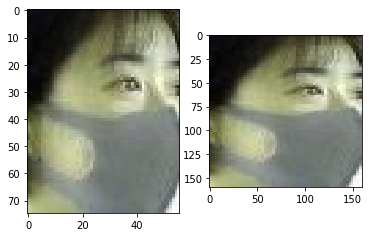

In [ ]:
next(img_miss)

In [ ]:
#size distribution fp

def get_width_height(df, delete = False, remove = False):
    error, pic_width, pic_height = [],[],[]
    for i in df.index:
        path = (folder + df['path'][i]).replace("\\","/")
        img = Image.open(path)
        if img is None:
            error.append(path)
            continue
        height, width= img.size
        if delete:
            if height< 100 or width <100:
                open(path, 'w').close()  # delete permanently
                os.remove(path)
        if remove:
            if height< 100 or width <100:
                new_path = remove +df['path'][i].split("\\")[-1]
                Path(path).rename(new_path)
        pic_width.append(width)
        pic_height.append(height)
    return error, pic_width,pic_height

In [ ]:
error_fp, pic_width_fp,pic_height_fp = get_width_height(fp)
error_fn, pic_width_fn,pic_height_fn = get_width_height(fn)
error, pic_width,pic_height = get_width_height(test_image)

In [ ]:
# for fp

# as we have check the samll images are more likely to be only partial face

count_small = max(len([i for i , v in enumerate(pic_height_fp) if v <100]),len([i for i , v in enumerate(pic_width_fp) if v <100]))
print(count_small, count_small/len(pic_height_fp))

# number of images smaller than 160 (at least one side)
smaller = max(len([i for i , v in enumerate(pic_height_fp) if v <160]),len([i for i , v in enumerate(pic_width_fp) if v <160]))
print(smaller,smaller/len(pic_height_fp))

48 0.05466970387243736
845 0.9624145785876993


In [ ]:
# for fn

# as we have check the samll images are more likely to be only partial face

count_small = max(len([i for i , v in enumerate(pic_height_fn) if v <100]),len([i for i , v in enumerate(pic_width_fn) if v <100]))
print(count_small, count_small/len(pic_height_fn))

# number of images smaller than 160 (at least one side)
smaller = max(len([i for i , v in enumerate(pic_height_fn) if v <160]),len([i for i , v in enumerate(pic_width_fn) if v <160]))
print(smaller, smaller/len(pic_height_fn))

294 0.29429429429429427
525 0.5255255255255256


In [ ]:
# the whole test set

# as we have check the samll images are more likely to be only partial face

count_small = max(len([i for i , v in enumerate(pic_height) if v <100]),len([i for i , v in enumerate(pic_width) if v <100]))
print(count_small, count_small/len(pic_height))

# number of images smaller than 160 (at least one side)
smaller = max(len([i for i , v in enumerate(pic_height) if v <160]),len([i for i , v in enumerate(pic_width) if v <160]))
print(smaller,  smaller/len(pic_height))

2478 0.06620711766591857
25399 0.6786095970930854


from the comparison above, for fn images the small(<100) images might be a reason for why they are miss classified. For fp it seems it contains a lot images whose size is smaller than 160. It seems that our algo is better on larger images.

Text(0.5, 1.0, 'images size in the whole test set')

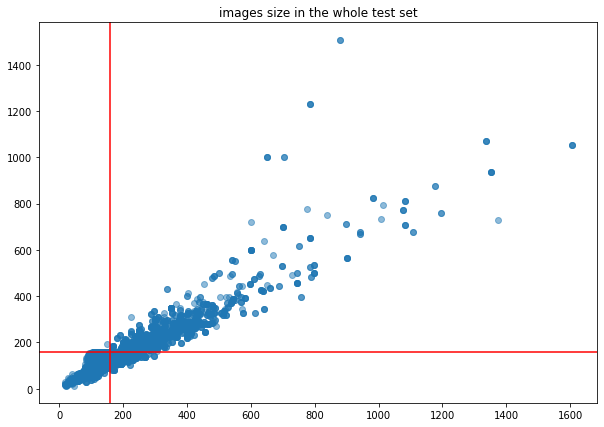

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(pic_width,pic_height, alpha= 0.5)
plt.axvline(x=160,color = 'r')
plt.axhline(y=160, color = 'r')
plt.title("images size in the whole test set")

Text(0.5, 1.0, 'images ratio(width/height) in the whole test set')

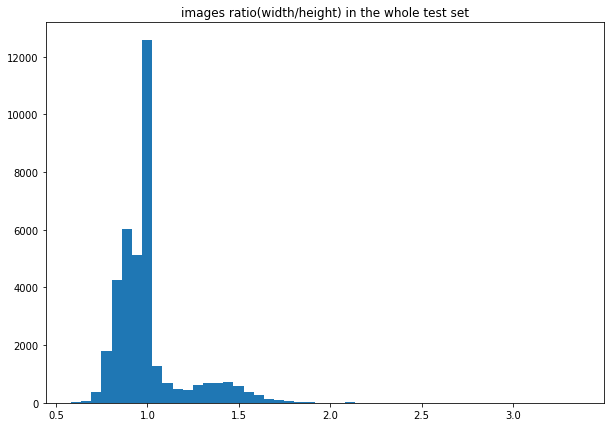

In [ ]:
ratio = [a/b for a, b in zip(pic_width, pic_height)]
plt.figure(figsize=(10,7))
plt.hist(ratio, bins = 50)
plt.title("images ratio(width/height) in the whole test set")

Text(0.5, 1.0, 'images size in fp')

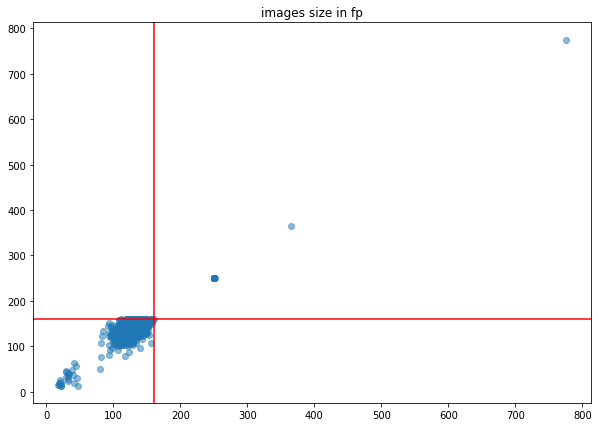

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(pic_width_fp,pic_height_fp, alpha= 0.5)
plt.axvline(x=160,color = 'r')
plt.axhline(y=160, color = 'r')
plt.title("images size in fp")

Text(0.5, 1.0, 'images ratio(width/height) in fp')

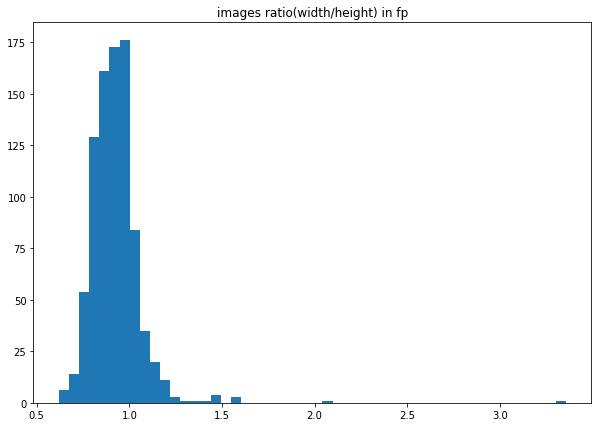

In [ ]:
ratio = [a/b for a, b in zip(pic_width_fp, pic_height_fp)]
plt.figure(figsize=(10,7))
plt.hist(ratio, bins = 50)
plt.title("images ratio(width/height) in fp")

Text(0.5, 1.0, 'images size in fn')

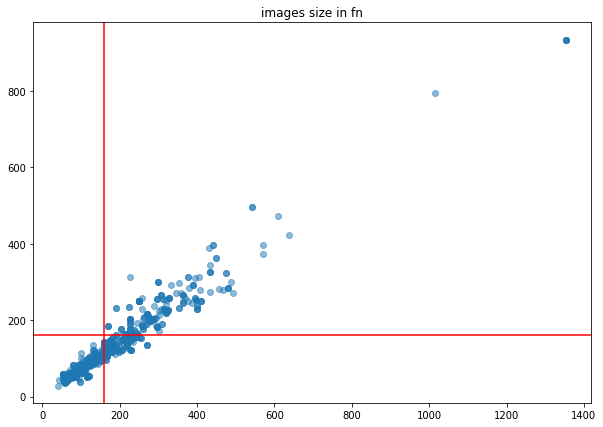

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(pic_width_fn,pic_height_fn, alpha= 0.5)
plt.axvline(x=160,color = 'r')
plt.axhline(y=160, color = 'r')
plt.title("images size in fn")

Text(0.5, 1.0, 'images ratio(width/height) in fn')

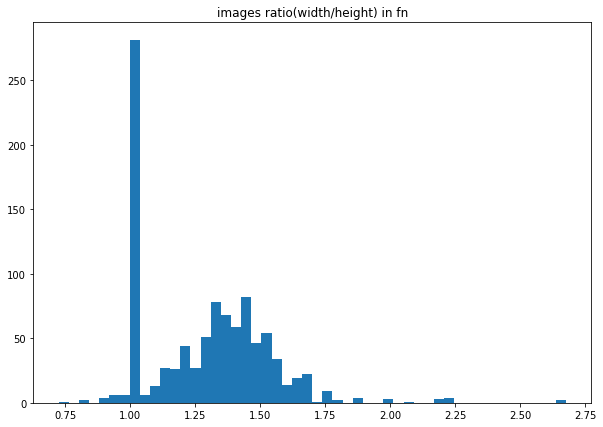

In [ ]:
ratio = [a/b for a, b in zip(pic_width_fn, pic_height_fn)]
plt.figure(figsize=(10,7))
plt.hist(ratio, bins = 50)
plt.title("images ratio(width/height) in fn")

most of the images are around 1 width/height ratio. In fp there is few images with large ratio, while in fn there is a lot with high ratio.

* not sure if we need to remove all images that have at least one side <100. It seems for fp they are compeletly wrong pic while for fn they are more likely to be an normal image.
* the ratio may more affect the fn
* not sure why there will be a lot fp images with size around 160-100?

# Next Step
* discuss if we need to remove all images less than 100
* change the resize function
* do the same for training set to see if we need to remove those small images
* manually check the test set and remove those without mouth or with wrong label
* normalize the embeddings

In [ ]:
# do the same for training set

error_train, pic_width_train,pic_height_train = get_width_height(train_image)

# as we have check the samll images are more likely to be only partial face

count_small = max(len([i for i , v in enumerate(pic_height_train) if v <100]),len([i for i , v in enumerate(pic_width_train) if v <100]))
print(count_small, count_small/len(pic_height_train))

# number of images smaller than 160 (at least one side)
smaller = max(len([i for i , v in enumerate(pic_height_train) if v <160]),len([i for i , v in enumerate(pic_width_train) if v <160]))
print(smaller,smaller/len(pic_height_train))

print(len(error_train))

7302 8.316628701594533
76829 0.6824937150775955
0


In [ ]:
print(count_small, count_small/len(pic_height_train))

7302 0.06486572918424817


In [ ]:
train_image.shape

(112571, 2)

Text(0.5, 1.0, 'images size in training set')

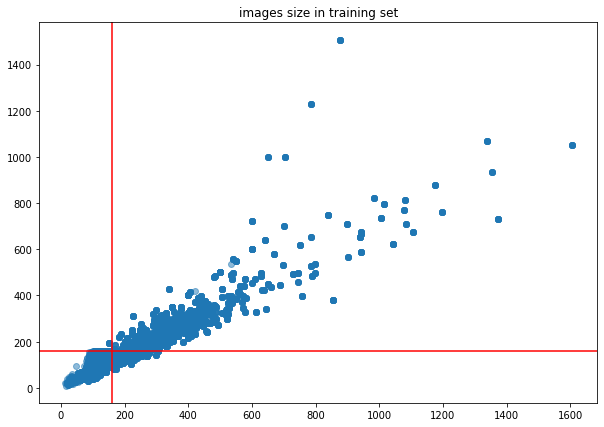

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(pic_width_train,pic_height_train, alpha= 0.5)
plt.axvline(x=160,color = 'r')
plt.axhline(y=160, color = 'r')
plt.title("images size in training set")

Text(0.5, 1.0, 'images ratio(width/height) in training set')

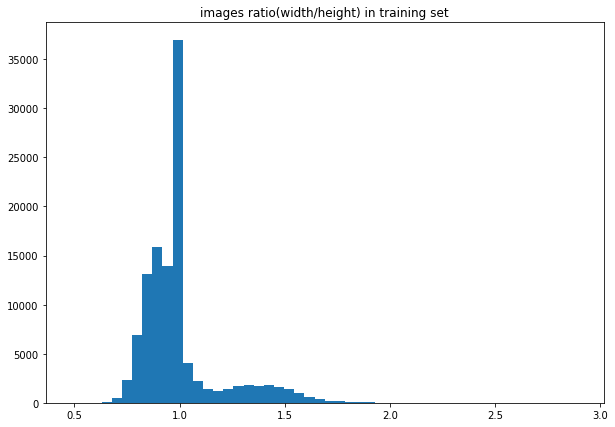

In [ ]:
ratio = [a/b for a, b in zip(pic_width_train, pic_height_train)]
plt.figure(figsize=(10,7))
plt.hist(ratio, bins = 50)
plt.title("images ratio(width/height) in training set")

The distribution of ratio and number of small images are quite same in training and test set
* should we remove the smaller(<100) images?

## remove the small images

In [ ]:
# remove all miss classified images to miss_c folder 

from pathlib import Path
def remove(df, current, destination):
    for i in df.index:
        try:
            path = (current + df['path'][i]).replace("\\","/")
            new_path = destination +df['path'][i].split("\\")[-1]
            Path(path).rename(new_path)
        except:
            continue






In [ ]:
remove(miss_classified_test, "data/", "data/miss_c")
# manually remove 187 low quality images

In [ ]:
# put those images back
for i in miss_classified_test.index:
    name = miss_classified_test['path'][i].split("\\")[-1]
    if name in os.listdir("data/miss_c"):
        path = "data/miss_c/" + name
        new_path = "data/" + miss_classified_test["path"][i].replace("\\","/")
        Path(path).rename(new_path)

In [ ]:
remove(fp,"data/","data/miss_c_fp/")
remove(fn,"data/","data/miss_c_fn/")

remove about 60 images from fp and fn including wrong labeled images and low quality images as well as face covered by something else other than mask.

In [ ]:
# put those images back
for i in miss_classified_test.index:
    name = miss_classified_test['path'][i].split("\\")[-1]
    if name in os.listdir("data/miss_c_fn"):
        path = "data/miss_c_fn/" + name
        new_path = "data/" + miss_classified_test["path"][i].replace("\\","/")
        Path(path).rename(new_path)
    if name in os.listdir("data/miss_c_fp"):
        path = "data/miss_c_fp/" + name
        new_path = "data/" + miss_classified_test["path"][i].replace("\\","/")
        Path(path).rename(new_path)

In [ ]:
# remove all small images(<100) to small_100_train/test folder

error_clean, pic_width_clean,pic_height_clean = get_width_height(test_image, remove ="data/small_100_test/")
error_train_clean, pic_width_train_clean,pic_height_train_clean = get_width_height(train_image, remove = "data/small_100_train/")

## number of images after cleaning
* test: 34873, testface:22250, trainmask:12622
* train: 105778, trainface:67934, trainmask:37843

we again have the imbalanced data problem...